In [1]:
# https://udemy.com/recommender-systems
# https://deeplearningcourses.com/recommender-systems
from __future__ import print_function, division
from builtins import range, input

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

from keras.models import Model
from keras.layers import Input, Embedding, Dot, Add, Flatten
from keras.regularizers import l2
from keras.optimizers import SGD, Adam

# load in the data
df = pd.read_csv('large_files/movielens-20m-dataset/edited_rating.csv')

N = df.userId.max() + 1 # number of users
M = df.movie_idx.max() + 1 # number of movies

# split into train and test
df = shuffle(df)
cutoff = int(0.8*len(df))
df_train = df.iloc[:cutoff]
df_test = df.iloc[cutoff:]
#nota: os warnings exibidos abaixo são provenientes do uso do tensorflow com a gpu e versoes do numpy suportadas

Using TensorFlow backend.
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Gustavo\anaconda3\lib\site-packages\tensorflow\python\framework\d

In [11]:
# ininicializando variaveis
K = 10 # latent dimensionality
mu = df_train.rating.mean()
epochs = 15
reg = 0.1# regularization penalty

# keras model
u = Input(shape=(1,))
m = Input(shape=(1,))
u_embedding = Embedding(N, K, embeddings_regularizer=l2(reg))(u) # embedding de usuario dim(N, 1, K)
m_embedding = Embedding(M, K, embeddings_regularizer=l2(reg))(m) # embedding de filme dim(N, 1, K)

#submodelo para prova de conceito das dimensoes das matrizes de saida
#usando embedding de u e m

# subsubmodel = Model([u, m], [u_embedding, m_embedding])
# user_ids = df_train.userId.values[0:5]
# movie_ids = df_train.movie_idx.values[0:5]
# print("user_ids.shape", user_ids.shape)
# p = subsubmodel.predict([user_ids, movie_ids])
# print("p[0].shape:", p[0].shape)
# print("p[1].shape:", p[1].shape)

#calculando bias de usuario e item
u_bias = Embedding(N, 1, embeddings_regularizer=l2(reg))(u) # embedding de bias usuario dim(N, 1, 1)
m_bias = Embedding(M, 1, embeddings_regularizer=l2(reg))(m) # embedding de bias filme dim(N, 1, 1)
x = Dot(axes=2)([u_embedding, m_embedding]) # dim(N, 1, 1)

#submodelo para prova de conceito das dimensoes das matrizes de saida
#usando o produto do embedding de u e m

# submodel = Model([u, m], x)
# user_ids = df_train.userId.values[0:5]
# movie_ids = df_train.movie_idx.values[0:5]
# p = submodel.predict([user_ids, movie_ids])
# print("p.shape:", p.shape)

#inserindo bias de usuario e item no produto das matrizes
x = Add()([x, u_bias, m_bias])
x = Flatten()(x) # (N, 1)

In [13]:
# definindo modelo e metrica de avaliacao(loss e mse, mse é diferente de loss quando usamos regularizacao)
model = Model(inputs=[u, m], outputs=x)
model.compile(
  loss='mse',
  # optimizer='adam',
  # optimizer=Adam(lr=0.01),
  optimizer=SGD(lr=0.08, momentum=0.9),
  metrics=['mse'],
)
# treinando o modelo e visualizando os resultados
r = model.fit(
  x=[df_train.userId.values, df_train.movie_idx.values],
  y=df_train.rating.values - mu,
  epochs=epochs,
  batch_size=128,
  validation_data=(
    [df_test.userId.values, df_test.movie_idx.values],
    df_test.rating.values - mu
  )
)

Train on 16000210 samples, validate on 4000053 samples
Epoch 1/15
16000210/16000210 [==============================] - 868s 54us/step - loss: 1.1286 - mse: 1.1038 - val_loss: 1.1192 - val_mse: 1.1041
Epoch 2/15
16000210/16000210 [==============================] - 827s 52us/step - loss: 1.1190 - mse: 1.1038 - val_loss: 1.1189 - val_mse: 1.1039
Epoch 3/15
16000210/16000210 [==============================] - 806s 50us/step - loss: 1.1190 - mse: 1.1038 - val_loss: 1.1198 - val_mse: 1.1045
Epoch 4/15
16000210/16000210 [==============================] - 806s 50us/step - loss: 1.1190 - mse: 1.1038 - val_loss: 1.1198 - val_mse: 1.1037
Epoch 5/15
16000210/16000210 [==============================] - 808s 50us/step - loss: 1.1190 - mse: 1.1038 - val_loss: 1.1186 - val_mse: 1.1045
Epoch 6/15
16000210/16000210 [==============================] - 815s 51us/step - loss: 1.1190 - mse: 1.1038 - val_loss: 1.1189 - val_mse: 1.1041
Epoch 7/15
16000210/16000210 [==============================] - 807s 50us/s

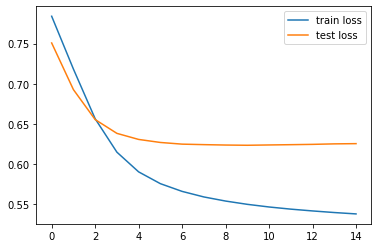

In [4]:
# plot losses
plt.plot(r.history['loss'], label="train loss")
plt.plot(r.history['val_loss'], label="test loss")
plt.legend()
plt.show()

In [5]:
#Plotamos o erro quadratico medio caso utilizemos regularizacao
#plot mse
#plt.plot(r.history['mse'], label="train mse")
#plt.plot(r.history['val_mse'], label="test mse")
#plt.legend()
#plt.show()